# 1. Describe the data
- We simulated with true model: $$ y = sin^3(2 \pi x^3) + ε, ε \sim N(0, (0.1)^2) $$
- The advantage of using simulated data is that we can see how close our methods come to the truth.

# 2. Load packages and create data

In [1]:
%%capture
pip install faraway

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import faraway.utils

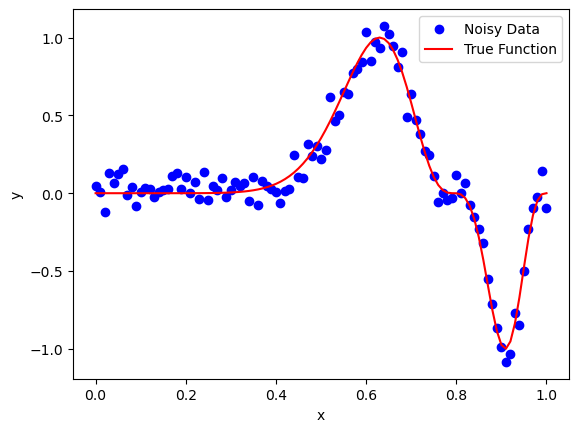

In [3]:
# Step 1: Define a custom function 'funeg'
def funeg(x):
    """
    This function takes an input 'x' and returns the value of the mathematical expression:
    sin(2 * pi * x^3)^3
    """
    return np.sin(2 * np.pi * x**3)**3

# Step 2: Generate a sequence of values for 'x'
x = np.linspace(0., 1., 101)  # 101 points between 0 and 1 (inclusive)

# Step 3: Create noisy data by adding random noise to the output of 'funeg(x)'
# 'sp.stats.norm.rvs(0, 0.1, 101)' generates 101 random values from 
# a normal distribution with mean=0 and std=0.1
y = funeg(x) + sp.stats.norm.rvs(0, 0.1, 101)

# Step 4: Plot the noisy data as a scatter plot
plt.scatter(x, y, label="Noisy Data", color='blue')  # Scatter plot for the noisy data

# Step 5: Plot the original function 'funeg(x)' without noise
plt.plot(x, funeg(x), label="True Function", color='red')  # Plot the true function (without noise)
plt.xlabel("x"); plt.ylabel("y"); plt.legend();

# 3. Polynomial Regression

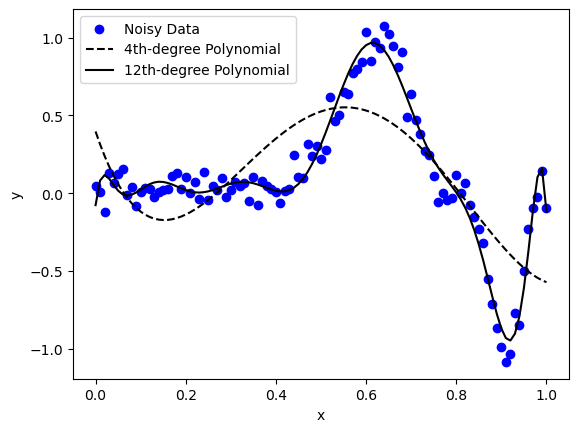

In [4]:
# PART 1: 4th-degree Polynomial 
# Step 1: Fit a 4th-degree polynomial to the data
# 'np.polyfit' fits a polynomial of degree 4 to the noisy data (x, y)
# 'np.poly1d' creates a polynomial function from the coefficients obtained by 'np.polyfit'
p = np.poly1d(np.polyfit(x, y, 4))

# Step 2: Plot the noisy data as a scatter plot
plt.scatter(x, y, label="Noisy Data", color='blue')  # Scatter plot for the noisy data

# Step 3: Plot the 4th-degree polynomial fit
plt.plot(x, p(x), 'k--', label="4th-degree Polynomial")  # Plot the 4th-degree polynomial as a dashed line ('k--' for black dashed line)

# PART 2: 12-the degree polynomial
# Step 1: Fit a 12th-degree polynomial to the data
# 'np.polyfit' fits a polynomial of degree 12 to the same noisy data (x, y)
p = np.poly1d(np.polyfit(x, y, 12))

# Step 2: Plot the 12th-degree polynomial fit
plt.plot(x, p(x), 'k-', label="12th-degree Polynomial")  # Plot the 12th-degree polynomial as a solid black line ('k-' for solid black line)

# Step 3: Add labels, legend, and display the plot
plt.xlabel("x"); plt.ylabel("y"); plt.legend();

- Degree 4 is clearly an underfit, while order 12 fits better but is too wiggly initially and misses the inflection point near ( x = 0.8 ).

# 4. B-spline
- A cubic B-spline basis can be defined on the interval [a, b] by meeting the following requirements for the interior basis functions with knotpoints at $t_1, \cdots, t_k$:
    - Each basis function is active only within a specific range defined by four consecutive knots. Outside this range, it is zero. This ensures that each data point influences only its own segment, offering localized control over the fit.
    - The basis function is a cubic polynomial within each subinterval between consecutive knots.
    - The basis function and its first and second derivatives are continuous at each knot. This means the function has no sharp corners or abrupt changes in curvature, ensuring a smooth fit. In spline regression, this smoothness is crucial for a realistic model that changes direction gradually.
    - The basis function integrates to one over its range, meaning the area under its curve is one. This normalization ensures all basis functions contribute equally to the model, keeping it stable and preventing any single function from dominating the fit.
    - The basis functions at the interval’s ends are adjusted to ensure smooth derivatives at the edges. Broken stick regression is an example of using linear splines.
- Regression splines are great for flexible function fitting if we have enough data. We can create basis functions for all predictors, but we must be cautious not to use too many degrees of freedom.

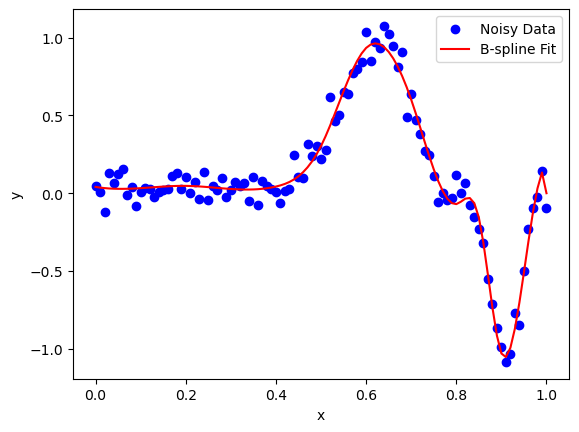

In [5]:
from patsy import bs
# Step 1: Define the knots for the B-spline
# The 'kts' array specifies the locations of the knots in the B-spline.
# These are points in the 'x' range where the spline basis functions will change.
kts = [0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 1]

# Step 2: Fit a B-spline model
# 'bs(x, knots=kts, include_intercept=True)' generates B-spline basis functions for the input data 'x'.
# These basis functions are then used to fit an Ordinary Least Squares (OLS) model to predict 'y'.
z = sm.OLS(y, bs(x, knots=kts, include_intercept=True)).fit()

# Step 3: Plot the noisy data as a scatter plot
plt.scatter(x, y, label="Noisy Data", color='blue')

# Step 4: Plot the fitted B-spline curve
# 'z.fittedvalues' contains the predicted values of 'y' based on the B-spline fit
plt.plot(x, z.fittedvalues, label="B-spline Fit", color='red')
plt.xlabel("x"); plt.ylabel("y"); plt.legend();

# 5. Smoothing splines
- An alternative to regression splines is smoothing splines. For the model $y_i = f(x_i) + ε_i $, we might use $\hat{f}$ to minimize the sum of squares. However, simply setting $\hat{f}(x_i) = y_i $ results in a “join the dots” regression, which is too rough. Instead, we minimize a modified least squares criterion:
$$ \frac{1}{n} \sum {(Y_i - f(x_i))}^2 + λ \int {[f"(x)]}^2 dx $$
- where λ > 0 controls the amount of smoothing and $\int {[f"(x)]}^2 dx$ is a roughness penalty.
- Thus, the criterion balances fit and smoothness, resulting in a smoothing spline fit.

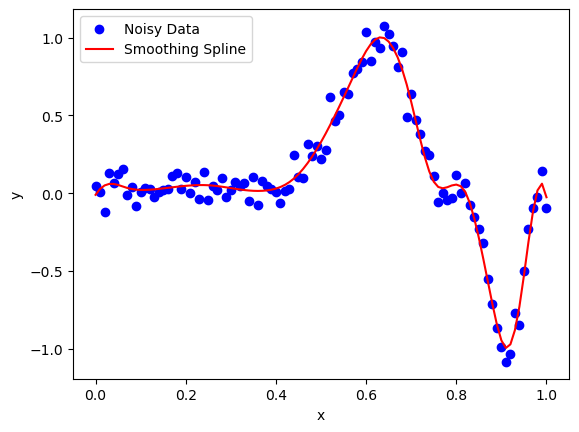

In [8]:
from scipy.interpolate import UnivariateSpline
# Step 1: Fit a smoothing spline to the noisy data
# 's' is the smoothing factor. A smaller 's' leads to less smoothing (closer to interpolation),
# and a larger 's' leads to more smoothing.
spline = UnivariateSpline(x, y, s=0.5) # 's=0.5' controls the smoothness (adjust as needed)

# Step 2: Plot the noisy data as a scatter plot
plt.scatter(x, y, label="Noisy Data", color='blue')

# Step 3: Plot the smoothing spline
plt.plot(x, spline(x), label="Smoothing Spline", color='red')
plt.xlabel("x"); plt.ylabel("y"); plt.legend();

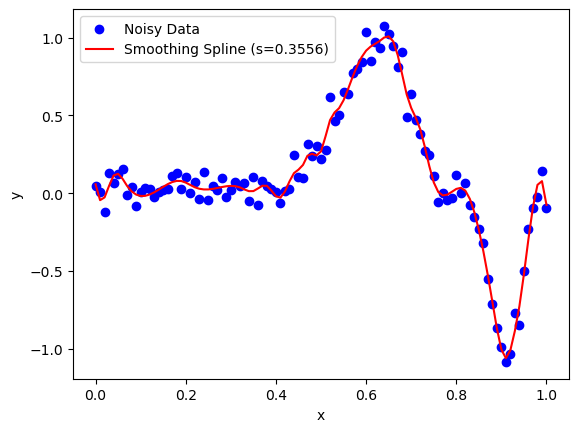

In [10]:
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
# Step 1: Define a function to perform cross-validation for smoothing spline
def crossval_smoothing_spline(x, y, s_values, k_folds=5):
    """
    Perform k-fold cross-validation to select the best smoothing factor 's'.
    
    Parameters:
        x: Independent variable (array-like).
        y: Dependent variable (noisy data, array-like).
        s_values: List of candidate smoothing factors to evaluate.
        k_folds: Number of cross-validation folds (default: 5).
    
    Returns:
        best_s: The optimal smoothing factor based on cross-validation.
        cv_errors: List of average cross-validation errors for each smoothing factor.
    """
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)  # Set up k-fold cross-validation
    cv_errors = []  # Store cross-validation error for each s

    # Loop through candidate smoothing factors
    for s in s_values:
        fold_errors = []  # Store error for each fold

        # Perform k-fold cross-validation
        for train_idx, test_idx in kf.split(x):
            x_train, x_test = x[train_idx], x[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            # Fit the smoothing spline on training set
            spline = UnivariateSpline(x_train, y_train, s=s)
            
            # Predict on test set and compute mean squared error
            y_pred = spline(x_test)
            fold_errors.append(mean_squared_error(y_test, y_pred))
        
        # Compute average error across all folds for the current s
        cv_errors.append(np.mean(fold_errors))

    # Step 6: Return s value with lowest average cross-validation error
    best_s = s_values[np.argmin(cv_errors)]
    return best_s, cv_errors
# Step 7: Define candidate smoothing factor values
s_values = np.logspace(-3, 2, 50)  # Candidate range of values for s

# Step 8: Perform cross-validation to find the best smoothing factor
best_s, cv_errors = crossval_smoothing_spline(x, y, s_values)

# Step 9: Fit the final model using the best smoothing factor
best_spline = UnivariateSpline(x, y, s=best_s)

# Step 10: Plot the noisy data and the fitted smoothing spline
plt.scatter(x, y, label="Noisy Data", color='blue')
plt.plot(x, best_spline(x), label=f"Smoothing Spline (s={best_s:.4f})", color='red')
plt.xlabel("x"); plt.ylabel("y"); plt.legend();